# Selection of krypton events in terms of S1 and S2

## Authors: JMH, JAH, GML, JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
from invisible_cities.io.pmaps_io import load_pmaps

In [1]:
print("Last updated on ", time.asctime())
MC = True
new_MC = True
new_MC_tag = ''
num_files_mc = 50
MC_offset = 0
if MC and new_MC:
    new_MC_tag = '_NEW'
    num_files_mc = 500
    MC_offset = 1
run_number = 7851 # pmaps exist for 7849, 7850, 7851
min_file = 0 # start offset from the 0th. "Late" starts from 1000.
num_files_data = 20
num_sipms_cap = 10

Last updated on  Tue Apr 28 15:13:53 2020


In [2]:
t0 = time.time()
last_time = t0

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

## Begin SiPM strength comparison

In [4]:
from invisible_cities.io.pmaps_io import load_pmaps

In [5]:
def four_digit(i):
    j = str(i)
    while len(j) < 4:
        j = '0'+j
    return j

# num_files_pmaps = num_files
# It will take around 4 hours if you want to read all of them in!!

# The normal MC location should be from now on '/Volumes/NEXT_data/IC_Data/simulation'

if not MC:
    num_files_pmaps = num_files_data # for data
    all_pmaps = ['/Volumes/NEXT_data/IC_Data/pmaps/'+str(run_number)+'/pmaps_'+four_digit(min_file + i)+'_'+str(run_number)+'_trigger1_v1.2.0_20191122_krbg1600.h5' for i in range(0, num_files_pmaps)]
else:
    num_files_pmaps = num_files_mc # for MC
    all_pmaps = ['/Volumes/NEXT_data/IC_Data/kdst/nexus_newKr_pmaps'+new_MC_tag+'/new.kr83m.pmaps.'+str(i)+'.h5' for i in range(MC_offset, num_files_pmaps + MC_offset)]

t0 = time.time()
my_pmaps = [load_pmaps(pmap_file) for pmap_file in all_pmaps]
print('Time to load', len(my_pmaps), 'pmaps =', time.time() - t0)

Time to load 20 pmaps = 108.27076411247253


In [6]:
# Re index events properly
def reindex(pmaps_list):    
    event_total = 0
    reindexed_pmaps = {}
    for i in range(len(pmaps_list)):
        keys = list(pmaps_list[i].keys())
        for k in keys:
            reindexed_pmaps[event_total] = pmaps_list[i][k]
            event_total += 1
    return reindexed_pmaps.copy()

In [7]:
# Select for 1 S1 and 1 S2
def s1s2selection(pmaps_list):
    print('Num events before selection =', len(pmaps_list))
    bad_keys = []

    for k in pmaps_list.keys():
        if not len(pmaps_list[k].s1s) == 1:
            bad_keys.append(k)
        elif not len(pmaps_list[k].s2s) == 1:
            bad_keys.append(k)
        elif len(pmaps_list[k].s2s[0].sipms.ids) == 0:
            bad_keys.append(k)
            print(k, 'HAS NO SIPM RESPONSE')
        
    for k in bad_keys:
        del pmaps_list[k]

    print('Num events after selection =', len(pmaps_list))

In [1]:
from invisible_cities.database import load_db

In [6]:
dir(load_db.DetDB)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'demopp',
 'new',
 'next100']

In [5]:
dir(load_db.DetectorGeo)

['__annotations__',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__wrapped__',
 'cache_clear',
 'cache_info']

In [8]:
# Select for central region
from invisible_cities.database import load_db
sipm_info = load_db.DataSiPM('new', -6400)
r_cut_mm = 100 # 10 cm radius cut

def sipm_center_cut(pmaps_list, radius):

    bad_keys = []

    for k in pmaps_list.keys():
        i = -1
        for j in range(len(pmaps_list[k].s2s[0].sipms.sum_over_times)):
            if i == -1:
                i = j
            elif pmaps_list[k].s2s[0].sipms.sum_over_times[j] > pmaps_list[k].s2s[0].sipms.sum_over_times[i]:
                i = j
        max_id = pmaps_list[k].s2s[0].sipms.ids[i]
        max_loc = sipm_info.iloc[max_id][['X', 'Y']]
        max_r = (max_loc['X']**2 + max_loc['Y']**2)**0.5

        if max_r > r_cut_mm:
            bad_keys.append(k)

    for k in bad_keys:
        del pmaps_list[k]

    print('Num events after position selection =', len(pmaps_list))

In [9]:
all_pmaps = reindex(my_pmaps)
s1s2selection(all_pmaps)
sipm_center_cut(all_pmaps, r_cut_mm)

Num events before selection = 6201
Num events after selection = 4722
Num events after position selection = 1128


In [10]:
# Figure out the minimum number of SiPMs (length of SiPM intensity vector)

num_sipms_min = -1

num_events = len(all_pmaps)
for k in all_pmaps.keys():
    if num_sipms_min == -1 or len(all_pmaps[k].s2s[0].sipms.sum_over_times) < num_sipms_min:
        num_sipms_min = len(all_pmaps[k].s2s[0].sipms.sum_over_times)

num_sipms_max = -1

num_events = len(all_pmaps)
for k in all_pmaps.keys():
    if num_sipms_max == -1 or len(all_pmaps[k].s2s[0].sipms.sum_over_times) > num_sipms_max:
        num_sipms_max = len(all_pmaps[k].s2s[0].sipms.sum_over_times)

# num_sipms_max = min(num_sipms_max, max_sipm_cap)
        
print('Min num SiPMs =', num_sipms_min)
print('Max num SiPMs =', num_sipms_max)
print('Number of events =', num_events)

Min num SiPMs = 12
Max num SiPMs = 56
Number of events = 1128


In [11]:
# Construct the average SiPM vector:
# avg_sipms[0] is the average signal in the strongest SiPM
# avg_sipms[1] is the average signal in the second strongest SiPM
# ... and so on

avg_sipms = list(np.zeros(num_sipms_max))
for k in all_pmaps.keys():
    sorted_energies = sorted(all_pmaps[k].s2s[0].sipms.sum_over_times, reverse = True)
        
    for sipm in range(len(sorted_energies)):
        avg_sipms[sipm] += sorted_energies[sipm] / num_events

In [12]:
# Construct the corresponding spread vector

avg_spread = list(np.zeros(num_sipms_max))
for k in all_pmaps.keys():

    sipm = 0
    sorted_energies = sorted(all_pmaps[k].s2s[0].sipms.sum_over_times, reverse = True)

    while sipm < len(sorted_energies):
        avg_spread[sipm] += (avg_sipms[sipm] - sorted_energies[sipm])**2 /num_events
        sipm += 1

    # Add 0s into standard deviation calculation for sipms that didn't register
    while sipm < num_sipms_max:
        avg_spread[sipm] += (avg_sipms[sipm])**2 /num_events
        sipm += 1
        
for sipm in range(num_sipms_max):
    avg_spread[sipm] = avg_spread[sipm]**0.5

In [13]:
sipm_nums = [x for x in range(num_sipms_max)]

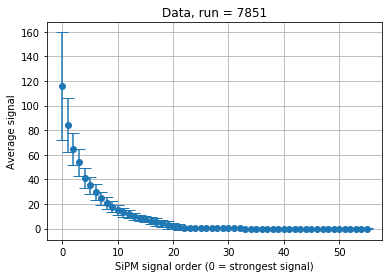

In [14]:
plt.errorbar(sipm_nums, avg_sipms, yerr = avg_spread, fmt = 'o', capsize = 6)
plt.xlabel('SiPM signal order (0 = strongest signal)')
plt.ylabel('Average signal')
if MC:
    plt.title('MC')
else:
    plt.title('Data, run = '+str(run_number))
plt.grid()
plt.show()

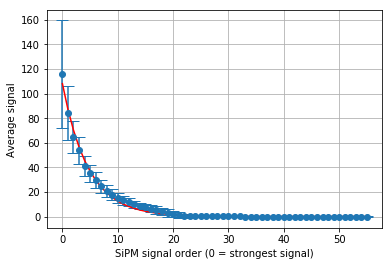

[108.07885381   0.2152964 ]


In [15]:
# Fit exponential decay to curve

from scipy.optimize import curve_fit

def exp(x, a, b):
    return a * np.exp(-b * x)

#def inv(x, a, b, c, d):
#    return a / (d + np.power(abs(x - b), c))

popt_exp, pcov_exp = curve_fit(exp, sipm_nums, avg_sipms)
#popt_inv, pcov_inv = curve_fit(inv, sipm_nums, avg_sipms)

sipm_nums = np.array(sipm_nums)

plt.errorbar(sipm_nums, avg_sipms, yerr = avg_spread, fmt = 'o', capsize = 6)
plt.xlabel('SiPM signal order (0 = strongest signal)')
plt.ylabel('Average signal')
plt.plot(sipm_nums, exp(sipm_nums, *popt_exp), 'r-')
#plt.plot(sipm_nums, inv(sipm_nums, *popt_inv), 'g--')
plt.grid()
plt.show()

print(popt_exp)

In [16]:
print(avg_sipms)

[115.96502914496334, 84.17183793859277, 64.5973366507401, 53.740937271862116, 41.15705492817768, 35.2774866219108, 29.64779301822609, 24.417468131011226, 20.68961080676274, 17.56013127379385, 15.159916164181732, 13.191580064753273, 11.445870589279966, 9.917905684904008, 8.59202603795003, 7.455492920486638, 6.388422667134743, 5.262038451560007, 4.102841882840959, 3.028607967052054, 2.071914827147276, 1.2282423474264483, 0.6230189132352247, 0.27421504850928663, 0.14362533379953804, 0.06271947782935824, 0.04367670649332358, 0.020888105774602147, 0.01539013149045038, 0.015264104444084436, 0.014377289207269113, 0.009743382744755306, 0.009294088850630091, 0.008641966691253878, 0.008477603290097934, 0.00842430828310919, 0.008141847366982318, 0.007948183844275508, 0.0065908854734813066, 0.006574769392081186, 0.005850139239155654, 0.005831924736077058, 0.005805630210443591, 0.005693559105514634, 0.005445058464158511, 0.00539806252675699, 0.005286434440748066, 0.005220020493717058, 0.00513972373

In [17]:
# NEW MC - 500 FILES. Decay constant: 0.2340
known_MC_avg = [25.888075926903593, 19.691803696225225, 15.84332095835617, 13.161929432675402, 10.707414788736553, 9.014924326763598, 7.54078958102242, 5.997778806631423, 4.316927895913051, 2.6764674119961147, 1.3373158040877093, 0.527874423722369, 0.16138970709573408, 0.04460790403687253, 0.007576977485195017, 0.0010310374645109085]

# OLD MC - 50 FILES. Decay constant: 0.2509
# known_MC_avg = [32.446950582576356, 22.642414330014184, 17.94196169419032, 14.564067684158422, 11.821789368009465, 10.080813814584122, 8.26357790016037, 6.769360098639728, 4.963066026183294, 2.8737226480518148, 1.6115713280664516, 0.6865329211559256, 0.24598980423944372, 0.03331484235304724, 0.010266498353324875]

# Decay constant: 0.2189
known_Data_avg_7851_0to20 = [118.35718705340145, 85.60926762650648, 64.88816617267895, 53.83612638333949, 41.34883529849176, 35.37706507799105, 29.763288532350117, 24.458116282021116, 20.67501141897063, 17.405608642857278, 15.07093955947132, 13.177858004221111, 11.42506666927803, 9.888952463661743, 8.579869079589848, 7.443799052354766, 6.42225849198132, 5.287538613110057, 4.096561057858346, 3.0706209796812476, 2.09772243964963, 1.2847259963431, 0.6667159173546765, 0.32472266080902845, 0.20261161990282014, 0.09678425626056951, 0.05819402555140054, 0.022324702565262956, 0.021821929187309453, 0.011682822064655584, 0.010850825426055163, 0.010722473888862424, 0.010228031437571455, 0.009510378953887195, 0.009329499035346798, 0.009270848530094798, 0.008960003736542493, 0.008746879391553926, 0.007253189086914063, 0.007235453535870808, 0.006438006889529345, 0.006417962051019436, 0.006389025246224752, 0.006265692361971227, 0.0059922204366544395, 0.005940501980665254, 0.005817656633330555, 0.005744568894549114, 0.005656203293218845, 0.005329595891440787, 0.005301877463736185, 0.005205024160989901, 0.005185858563679021, 0.005107358606850228, 0.005061690167682927, 0.004894547346161633]

# Decay constant: 0.2218
known_Data_avg_7850_0to20 = [119.10549628117171, 85.84162255397364, 65.3237857514644, 54.29688875798675, 40.956309761184215, 34.89218999475122, 29.31595397280504, 24.052565700029476, 20.333593858190703, 17.267844539714535, 14.939490873975112, 13.01464187908934, 11.29700192797231, 9.863897202024416, 8.574326475777944, 7.4142616217829795, 6.30175952702405, 5.251153954471723, 4.16708090770767, 3.0478246625201133, 2.082158042615155, 1.2581304748694728, 0.678165270987735, 0.3272748140699836, 0.1409201873726104, 0.07432022322696519, 0.050967586942877896, 0.022707794766977013, 0.011259928167578708, 0.00955705243752772, 0.009171167692815166, 0.009166570298700218, 0.009136310136650663, 0.008803120647293638, 0.008549703544829472, 0.008520635475675423, 0.00792190658143792, 0.0075928124773549845, 0.007481080127427302, 0.007374557365934212, 0.007338170511314118, 0.0071419643690861555, 0.006576629273919945, 0.006531251854155643, 0.006412083409221999, 0.006394471780237449, 0.006299804406337054, 0.005856409015883487, 0.005763319858991768, 0.005494392250638559, 0.005232476143248053, 0.005133448843936996, 0.005043326621036606]

# Decay constant: 0.2203
known_Data_avg_7851_1000to1020 = [119.77477146017151, 85.50933711611003, 65.26900343683546, 54.60737305439168, 41.223931183838516, 35.30197904051227, 29.39821760713171, 24.32503930171723, 20.50496926331166, 17.47024637513559, 15.202621119362977, 13.313321891089359, 11.572141796732165, 10.106743976987627, 8.832109536325984, 7.654775360182603, 6.518681066259376, 5.369468209778738, 4.303027772668547, 3.1586712752656987, 2.2227596071553344, 1.4074498857770648, 0.798368910615667, 0.41115097506292936, 0.19909120334193034, 0.11263914296192488, 0.05791487200506802, 0.04032353697151973, 0.009951758737047317, 0.004935211031307728]

# Decay constant: 0.2204
known_Data_avg_7850_1000to1020 = [118.39726912085668, 85.64230392228319, 65.93262695732398, 54.4342532851803, 41.05310585427641, 34.98616068576709, 29.454869946437082, 24.123084783554052, 20.38641983582014, 17.222139723710157, 14.891911351858695, 13.014920754219148, 11.316485779054137, 9.892522428907567, 8.650424231344209, 7.423025670781061, 6.3472796300453975, 5.217888691532079, 4.119387003468042, 2.936694190573338, 1.8643489609013753, 1.1412801973855318, 0.5763962980526596, 0.2764683881802345, 0.15071199456257603, 0.0681006419124888, 0.03396953086354839, 0.019344159471454906, 0.004786615941061902]


# min_data = min(len(known_Data_avg_7850_to20), len(known_Data_avg_7851_0to20))
# sipm_nums_min_data =[x for x in range(min_data)]

# plt.plot(sipm_nums_min_data, known_Data_avg_7850_0to20[:min_data], 'o')
# plt.plot(sipm_nums_min_data, known_Data_avg_7851_0to20[:min_data], 'o')
# plt.grid()
# plt.show()

In [18]:
def curve_compare(curve_1, curve_2, name):
    curve_compare_1 = curve_1[:num_sipms_cap]
    curve_compare_2 = curve_2[:num_sipms_cap]
    ratio = [curve_compare_1[i] / curve_compare_2[i] for i in range(min(len(curve_compare_1), len(curve_compare_2)))]
    sipm_nums_min = [x for x in range(len(ratio))]
    plt.plot(sipm_nums_min, ratio, 'o')
    plt.xlabel('SiPM signal order')
    plt.ylabel('Signal ratio')
    plt.title(name)
    plt.grid()
    plt.show()

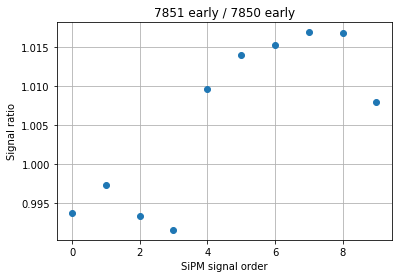

In [19]:
curve_compare(known_Data_avg_7851_0to20, known_Data_avg_7850_0to20, '7851 early / 7850 early')

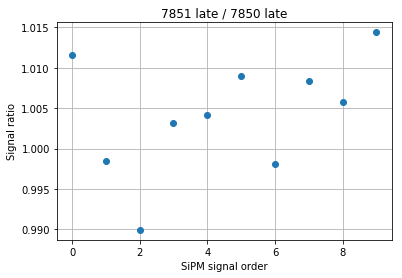

In [20]:
curve_compare(known_Data_avg_7851_1000to1020, known_Data_avg_7850_1000to1020, '7851 late / 7850 late')

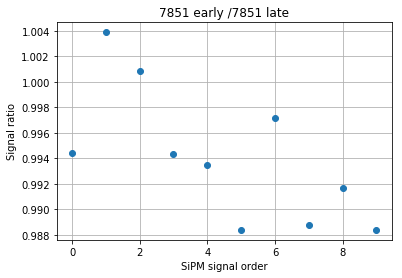

In [21]:
curve_compare(known_Data_avg_7850_0to20, known_Data_avg_7851_1000to1020, '7851 early /7851 late')

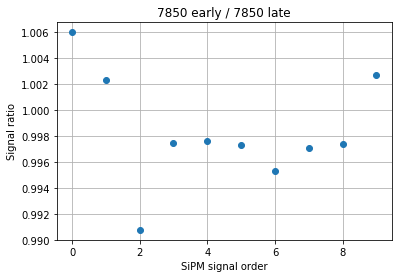

In [22]:
curve_compare(known_Data_avg_7850_0to20, known_Data_avg_7850_1000to1020, '7850 early / 7850 late')

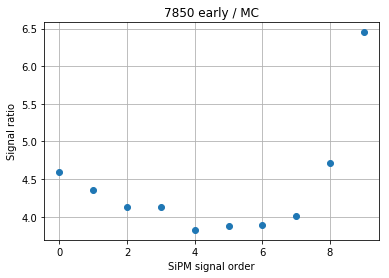

In [23]:
curve_compare(known_Data_avg_7850_0to20, known_MC_avg, '7850 early / MC')

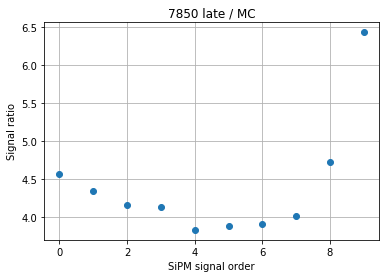

In [24]:
curve_compare(known_Data_avg_7850_1000to1020, known_MC_avg, '7850 late / MC')

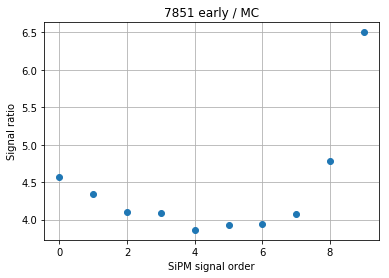

In [25]:
curve_compare(known_Data_avg_7851_0to20, known_MC_avg, '7851 early / MC')

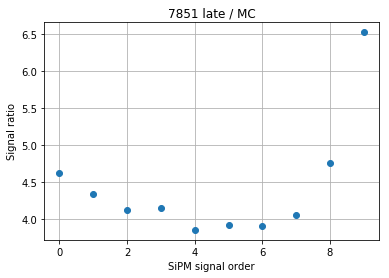

In [26]:
curve_compare(known_Data_avg_7851_1000to1020, known_MC_avg, '7851 late / MC')

In [27]:
dir(all_pmaps[list(all_pmaps.keys())[0]].s1s[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_valid_input',
 'bin_widths',
 'charge_above_threshold',
 'energy_above_threshold',
 'height',
 'pmts',
 'rms',
 'rms_above_threshold',
 'sipms',
 'time_at_max_energy',
 'times',
 'total_charge',
 'total_energy',
 'width',
 'width_above_threshold']

In [28]:
all_s1_energies = [all_pmaps[k].s1s[0].total_energy for k in all_pmaps.keys()]
all_s1_heights = [all_pmaps[k].s1s[0].height for k in all_pmaps.keys()]
all_s1_widths = [all_pmaps[k].s1s[0].width for k in all_pmaps.keys()]
all_s1_rms = [all_pmaps[k].s1s[0].rms for k in all_pmaps.keys()]

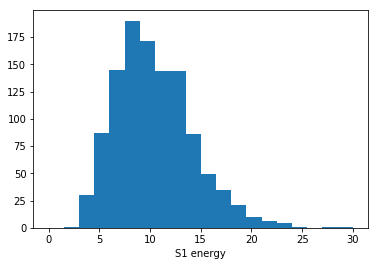

In [29]:
plt.hist(all_s1_energies, bins = 20, range = (0, 30))
plt.xlabel('S1 energy')
plt.show()

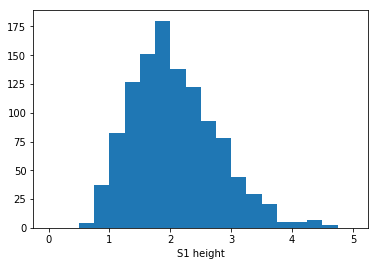

In [30]:
plt.hist(all_s1_heights, bins = 20, range = (0, 5))
plt.xlabel('S1 height')
plt.show()

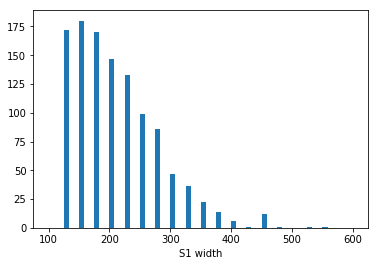

In [31]:
plt.hist(all_s1_widths, bins = 60, range = (100, 600))
plt.xlabel('S1 width')
plt.show()

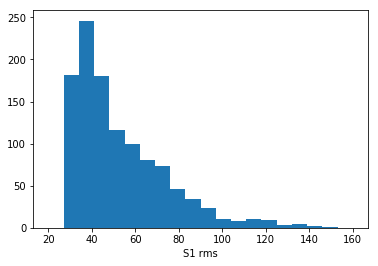

In [32]:
plt.hist(all_s1_rms, bins = 20, range = (20, 160))
plt.xlabel('S1 rms')
plt.show()

In [33]:
num_files_pmaps = num_files_data
file_pmaps = ['/Volumes/NEXT_data/IC_Data/pmaps/'+str(run_number)+'/pmaps_'+four_digit(min_file + i)+'_'+str(run_number)+'_trigger1_v1.2.0_20191122_krbg1600.h5' for i in range(0, num_files_pmaps)]

t0 = time.time()
my_data_pmaps = [load_pmaps(pmap_file) for pmap_file in file_pmaps]
print('Time to load', len(my_data_pmaps), 'pmaps =', time.time() - t0)

Time to load 20 pmaps = 97.74226903915405


In [34]:
data_pmaps = reindex(my_data_pmaps)
s1s2selection(data_pmaps)
sipm_center_cut(data_pmaps, r_cut_mm)

Num events before selection = 6201
Num events after selection = 4722
Num events after position selection = 1128


In [35]:
all_s1_energies_data = [data_pmaps[k].s1s[0].total_energy for k in data_pmaps.keys()]
all_s1_heights_data = [data_pmaps[k].s1s[0].height for k in data_pmaps.keys()]
all_s1_widths_data = [data_pmaps[k].s1s[0].width for k in data_pmaps.keys()]
all_s1_rms_data = [data_pmaps[k].s1s[0].rms for k in data_pmaps.keys()]

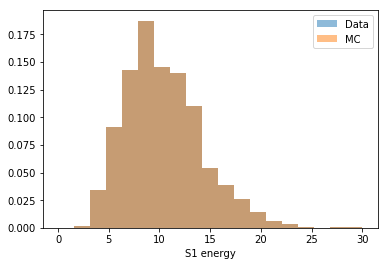

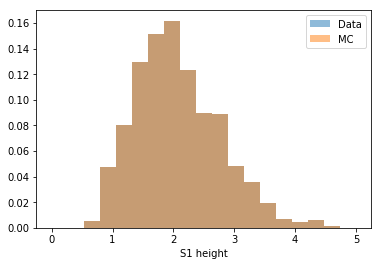

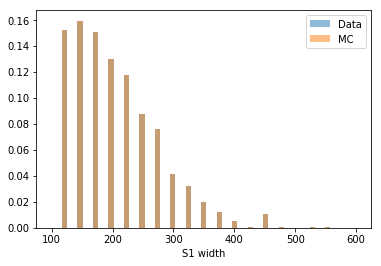

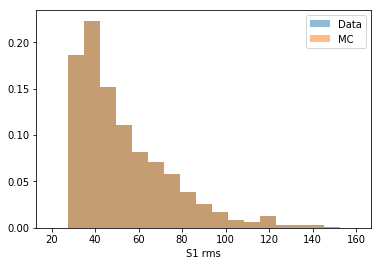

In [36]:
def compare_hist(characteristic, set_mc, set_data, xmin, xmax, nbins):
    (counts_data, bins_data) = np.histogram(set_data, bins=np.linspace(xmin, xmax, nbins))
    (counts_mc, bins_mc) = np.histogram(set_mc, bins=np.linspace(xmin, xmax, nbins))

    plt.hist(bins_data[:-1], bins_data, weights=counts_data/sum(counts_data), alpha = 0.5, label='Data')
    plt.hist(bins_mc[:-1], bins_mc, weights=counts_mc/sum(counts_mc), alpha = 0.5, label='MC')
    plt.xlabel(characteristic)
    plt.legend(loc='upper right')
    plt.show()
    
compare_hist('S1 energy', all_s1_energies, all_s1_energies_data, 0, 30, 20)
compare_hist('S1 height', all_s1_heights, all_s1_heights_data, 0, 5, 20)
compare_hist('S1 width', all_s1_widths, all_s1_widths_data, 100, 600, 60)
compare_hist('S1 rms', all_s1_rms, all_s1_rms_data, 20, 160, 20)

In [181]:
# Select for central region
from invisible_cities.database import load_db
sipm_info = load_db.DataSiPM('new', -6400)
r_cut_mm = 100 # 10 cm radius cut

def sipm_center_cut(pmaps_list, radius):

    bad_keys = []

    for k in pmaps_list.keys():
        i = -1
        for j in range(len(pmaps_list[k].s2s[0].sipms.sum_over_times)):
            if i == -1:
                i = j
            elif pmaps_list[k].s2s[0].sipms.sum_over_times[j] > pmaps_list[k].s2s[0].sipms.sum_over_times[i]:
                i = j
        max_id = pmaps_list[k].s2s[0].sipms.ids[i]
        max_loc = sipm_info.iloc[max_id][['X', 'Y']]
        max_r = (max_loc['X']**2 + max_loc['Y']**2)**0.5

        if max_r > r_cut_mm:
            bad_keys.append(k)

    for k in bad_keys:
        del pmaps_list[k]

    print('Num events after position selection =', len(pmaps_list))

In [137]:
# Select for 1 S1 and 1 S2
def s1s2selection(pmaps_list):
    print('Num events before selection =', len(pmaps_list))
    bad_keys = []

    for k in pmaps_list.keys():
        if not len(pmaps_list[k].s1s) == 1:
            bad_keys.append(k)
        elif not len(pmaps_list[k].s2s) == 1:
            bad_keys.append(k)
        elif len(pmaps_list[k].s2s[0].sipms.ids) == 0:
            bad_keys.append(k)
            print(k, 'HAS NO SIPM RESPONSE')
        
    for k in bad_keys:
        del pmaps_list[k]

    print('Num events after selection =', len(pmaps_list))

In [138]:
# Re index events properly
def reindex(pmaps_list):    
    event_total = 0
    reindexed_pmaps = {}
    for i in range(len(pmaps_list)):
        keys = list(pmaps_list[i].keys())
        for k in keys:
            reindexed_pmaps[event_total] = pmaps_list[i][k]
            event_total += 1
    return reindexed_pmaps.copy()

In [139]:
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
from invisible_cities.io.pmaps_io import load_pmaps

In [140]:
def four_digit(i):
    j = str(i)
    while len(j) < 4:
        j = '0'+j
    return j

In [185]:
def read_in_cut_pmaps(myallpmaps, r_cut_mm):
    t0 = time.time()
    print('Loading', myallpmaps[0], 'to', myallpmaps[-1])
    my_pmaps = [load_pmaps(pmap_file) for pmap_file in myallpmaps]
    print('Time to load', len(my_pmaps), 'pmaps =', time.time() - t0)
    my_pmaps = reindex(my_pmaps)
    s1s2selection(my_pmaps)
    sipm_center_cut(my_pmaps, r_cut_mm)
    return my_pmaps

In [186]:
r_cut_mm = 100 # 10 cm radius cut

# The normal MC location should be from now on '/Volumes/NEXT_data/IC_Data/simulation'. Remember
# when moving over data to look at irene outputs, even if you have to go up a few directories
# to find it.

# all_pmaps = ['/Volumes/NEXT_data/IC_Data/kdst/nexus_newKr_pmaps_NEW/new.kr83m.pmaps.'+str(i)+'.h5' for i in range(1, 501)]

# Run, offset, num_files
run_number = 7851
offset = 20
num_files = 20
data_pmaps_files = ['/Volumes/NEXT_data/IC_Data/pmaps/'+str(run_number)+'/pmaps_'+four_digit(i)+'_'+str(run_number)+'_trigger1_v1.2.0_20191122_krbg1600.h5' for i in range(offset, offset + num_files)] # 20 is chosen because using all would take hours to read in

# 20200427. Flat 50% reflectance. No PEDOT
# mc_date = '20200427'
# mc_pmaps_files = ['/Volumes/NEXT_data/IC_Data/simulation/20200427/new.kr83m.pmaps.'+str(i)+'.h5' for i in range(1, 501)]

# 20200430. 10% blue light, 0% VUV
# mc_date = '20200430'
# mc_pmaps_files = ['/Volumes/NEXT_data/IC_Data/pmaps/mc20200430/new.kr83m.hypathia.'+str(i)+'.h5' for i in range(1, 501)]

# 20200429
mc_date = '20200429'
mc_pmaps_files = ['/Volumes/NEXT_data/IC_Data/pmaps/mc'+mc_date+'/new.kr83m.hypathia.'+str(i)+'.h5' for i in range(1, 501)]

In [187]:
# 8 minutes to load any recent (500 file) MC
# 2 minutes to load old MC
# 1 minute to load 20 files of data
data_pmaps = read_in_cut_pmaps(data_pmaps_files, r_cut_mm)

Loading /Volumes/NEXT_data/IC_Data/pmaps/7851/pmaps_0020_7851_trigger1_v1.2.0_20191122_krbg1600.h5 to /Volumes/NEXT_data/IC_Data/pmaps/7851/pmaps_0039_7851_trigger1_v1.2.0_20191122_krbg1600.h5
Time to load 20 pmaps = 113.82571291923523
Num events before selection = 6215
Num events after selection = 4732
Num events after position selection = 1140


In [188]:
mc_pmaps = read_in_cut_pmaps(mc_pmaps_files, r_cut_mm)

Loading /Volumes/NEXT_data/IC_Data/pmaps/mc20200429/new.kr83m.hypathia.1.h5 to /Volumes/NEXT_data/IC_Data/pmaps/mc20200429/new.kr83m.hypathia.500.h5
Time to load 500 pmaps = 1459.0241668224335
Num events before selection = 49952
Num events after selection = 27966
Num events after position selection = 6535


In [189]:
pmt_data = load_db.DataPMT('new', 7851)
pmt_radii = np.array([pmt_data['X'][i]**2 + pmt_data['Y'][i]**2 for i in range(0, 12)])
all_ids = np.array([ i for i in range(12)])
inner_cutoff = 5000
inner_indices = all_ids[pmt_radii <= inner_cutoff]
outer_indices = all_ids[pmt_radii > inner_cutoff]

In [190]:
def drift_times_from_pmaps(allpmaps):
    return {k : 0.97 * (allpmaps[k].s2s[0].time_at_max_energy / 1000 - allpmaps[k].s1s[0].time_at_max_energy / 1000) for k in allpmaps.keys() }

In [191]:
def partial_average(allpmaps, subindices):
    allsum = 0
    num = 0
    for i in subindices:
        for k in allpmaps.keys():
            if i in allpmaps[k].s2s[0].pmts.ids:
                allsum += allpmaps[k].s2s[0].pmts.sum_over_times[i]
                num += 1
    return allsum / num
    # return np.average([[allpmaps[k].s2s[0].pmts.sum_over_times[i] for i in subindices] for k in data_pmaps.keys()])

In [192]:
r7851_inner = 1160.4229
r7851_outer = 885.17426

nexus_newKr_pmaps_NEW_inner = 218.75660187255474 # nexus_newKr_pmaps_NEW
nexus_newKr_pmaps_NEW_outer = 145.59450294753233 # nexus_newKr_pmaps_NEW

nexus_20200427_inner = 405.68195495727736
nexus_20200427_outer = 276.7825584972007

In [193]:
def partial_average_drift(allpmaps, subindices, zrange, drifttimes):
    allsum = 0
    num = 0
    for i in subindices:
        for k in allpmaps.keys():
            if zrange[0] <= drifttimes[k] < zrange[1]:
                if i in allpmaps[k].s2s[0].pmts.ids:
                    allsum += allpmaps[k].s2s[0].pmts.sum_over_times[i]
                    num += 1
    return allsum / num
    # return np.average([[allpmaps[k].s2s[0].pmts.sum_over_times[i] for i in subindices] for k in data_pmaps.keys()])

In [194]:
def partial_average_drift_s1(allpmaps, subindices, zrange, drifttimes):
    allsum = 0
    num = 0
    for i in subindices:
        for k in allpmaps.keys():
            if zrange[0] <= drifttimes[k] < zrange[1]:
                if i in allpmaps[k].s2s[0].pmts.ids:
                    allsum += allpmaps[k].s1s[0].pmts.sum_over_times[i]
                    num += 1
    return allsum / num


In [195]:
drift_times_mc = drift_times_from_pmaps(mc_pmaps)
drift_times_data = drift_times_from_pmaps(data_pmaps)

In [196]:
zcuts = [0, 100, 200, 300, 400, 520]
zranges = [[zcuts[i], zcuts[i+1]] for i in range(len(zcuts)-1)]

In [197]:
def ratios_vs_z(allpmaps, drifttimes, zranges):
    return [partial_average_drift(allpmaps, inner_indices, zrange, drifttimes) / partial_average_drift(allpmaps, outer_indices, zrange, drifttimes) for zrange in zranges]

def ratios_vs_z_s1(allpmaps, drifttimes, zranges):
    return [partial_average_drift_s1(allpmaps, inner_indices, zrange, drifttimes) / partial_average_drift_s1(allpmaps, outer_indices, zrange, drifttimes) for zrange in zranges]

In [198]:
print('Data average ratio S2 = ', ratios_vs_z(data_pmaps, drift_times_data, [[0, 520]]))
print('MC average ratio S2 = ', ratios_vs_z(mc_pmaps, drift_times_mc, [[0, 520]]))
print('Data average ratio S1 = ', ratios_vs_z_s1(data_pmaps, drift_times_data, [[0, 520]]))
print('MC average ratio S1 = ', ratios_vs_z_s1(mc_pmaps, drift_times_mc, [[0, 520]]))

Data average ratio S2 =  [1.3122044079134123]
MC average ratio S2 =  [1.4732963927338643]
Data average ratio S1 =  [1.504860674894391]
MC average ratio S1 =  [1.4990732731990608]


In [199]:
ratios_mc = ratios_vs_z(mc_pmaps, drift_times_mc, zranges)
ratios_data = ratios_vs_z(data_pmaps, drift_times_data, zranges)

In [200]:
s1_ratios_mc = ratios_vs_z_s1(mc_pmaps, drift_times_mc, zranges)
s1_ratios_data = ratios_vs_z_s1(data_pmaps, drift_times_data, zranges)

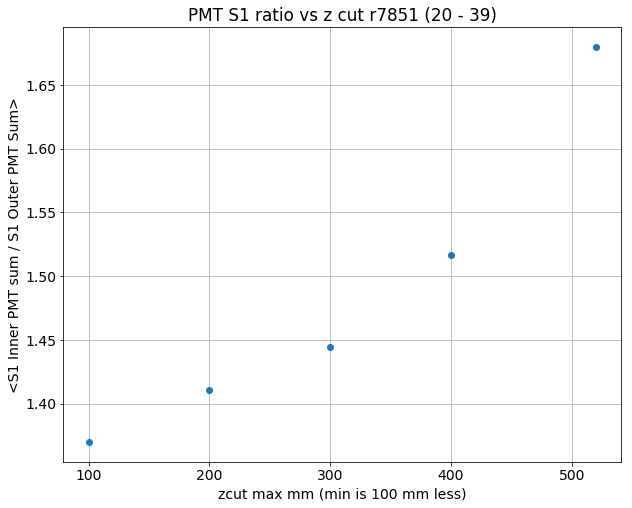

In [201]:
plt.plot(zcuts[1:], s1_ratios_data, 'o')
plt.xlabel('zcut max mm (min is 100 mm less)')
plt.ylabel('<S1 Inner PMT sum / S1 Outer PMT Sum>')
plt.title('PMT S1 ratio vs z cut r7851 ('+str(offset)+' - '+str(offset+num_files-1)+')')
plt.grid()
plt.show()

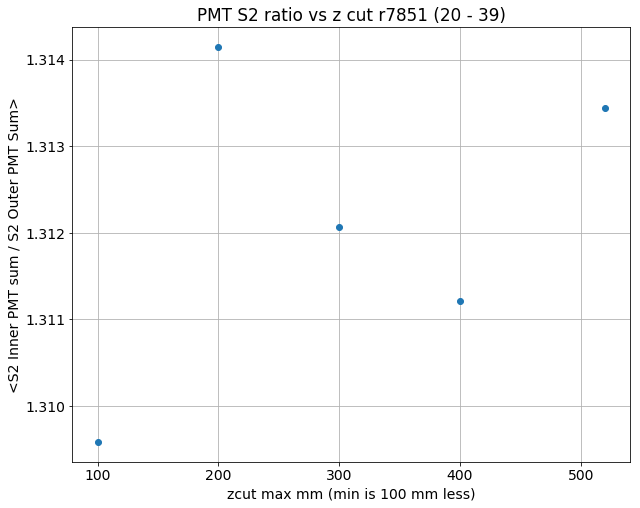

In [202]:
plt.plot(zcuts[1:], ratios_data, 'o')
plt.xlabel('zcut max mm (min is 100 mm less)')
plt.ylabel('<S2 Inner PMT sum / S2 Outer PMT Sum>')
plt.title('PMT S2 ratio vs z cut r7851 ('+str(offset)+' - '+str(offset+num_files-1)+')')
plt.grid()
plt.show()

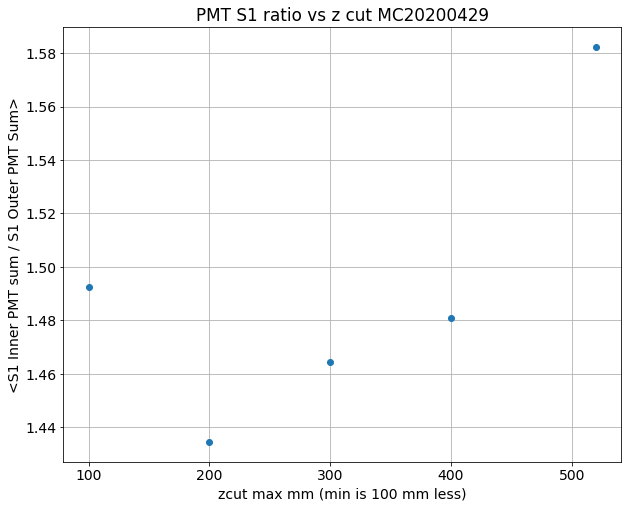

In [203]:
plt.plot(zcuts[1:], s1_ratios_mc, 'o')
plt.xlabel('zcut max mm (min is 100 mm less)')
plt.ylabel('<S1 Inner PMT sum / S1 Outer PMT Sum>')
plt.title('PMT S1 ratio vs z cut MC'+mc_date)
plt.grid()
plt.show()

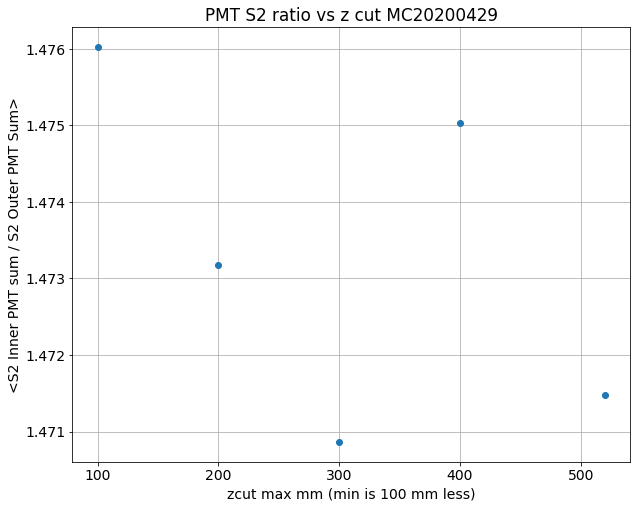

In [204]:
plt.plot(zcuts[1:], ratios_mc, 'o')
plt.xlabel('zcut max mm (min is 100 mm less)')
plt.ylabel('<S2 Inner PMT sum / S2 Outer PMT Sum>')
plt.title('PMT S2 ratio vs z cut MC'+mc_date)
plt.grid()
plt.show()

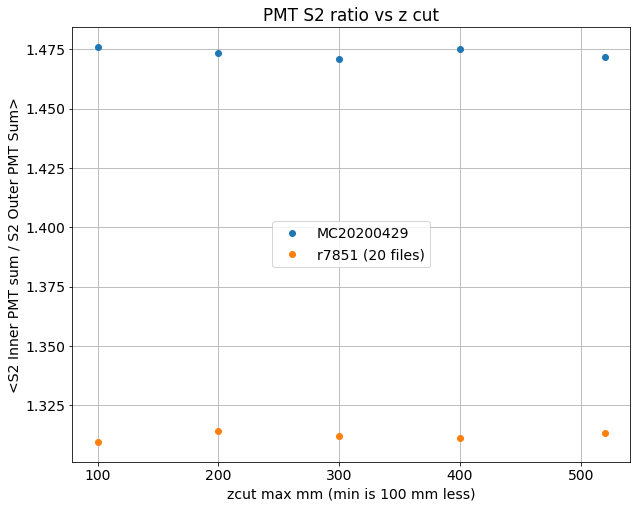

In [205]:
plt.plot(zcuts[1:], ratios_mc, 'o', label = 'MC'+mc_date)
plt.plot(zcuts[1:], ratios_data, 'o', label = 'r7851 (20 files)')
plt.xlabel('zcut max mm (min is 100 mm less)')
plt.ylabel('<S2 Inner PMT sum / S2 Outer PMT Sum>')
plt.title('PMT S2 ratio vs z cut')
plt.legend(loc='center')
plt.grid()
plt.show()

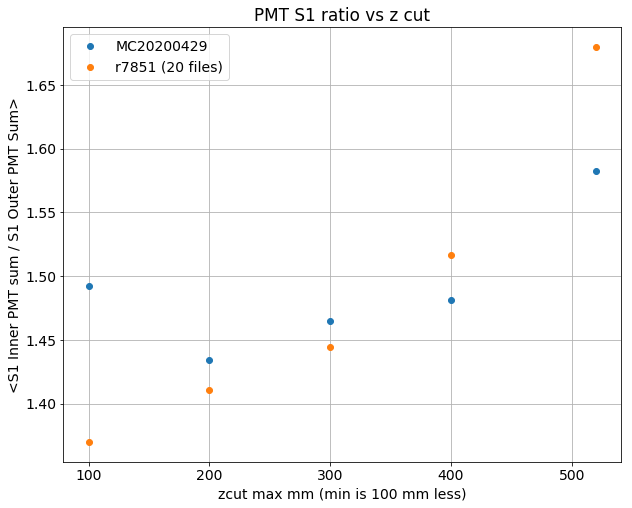

In [206]:
plt.plot(zcuts[1:], s1_ratios_mc, 'o', label = 'MC'+mc_date)
plt.plot(zcuts[1:], s1_ratios_data, 'o', label = 'r7851 (20 files)')
plt.xlabel('zcut max mm (min is 100 mm less)')
plt.ylabel('<S1 Inner PMT sum / S1 Outer PMT Sum>')
plt.title('PMT S1 ratio vs z cut')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [207]:
s1_ratios_mc[0]

1.4926071022368255

In [208]:
s1_ratios_data[0]

1.3698137687420753

In [209]:
ratios_mc[0]

1.4760270112740188

In [210]:
ratios_data[0]

1.3095843345132212

In [211]:
inner_indices

array([0, 1, 2])

In [212]:
print(ratios_mc)

[1.4760270112740188, 1.4731795080479575, 1.470864328820543, 1.4750344774727053, 1.4714816587338322]


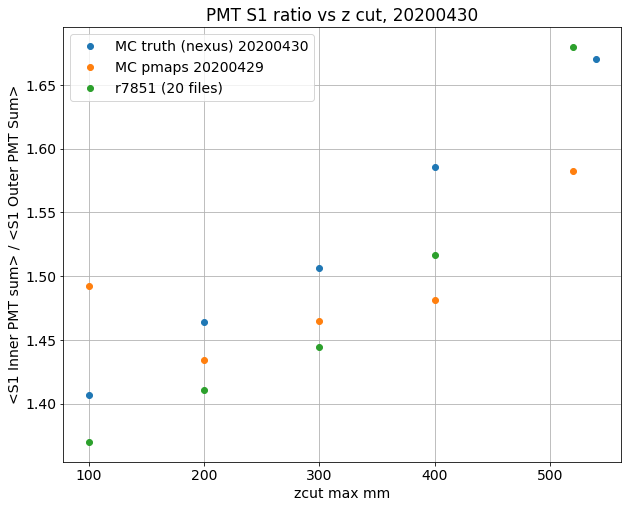

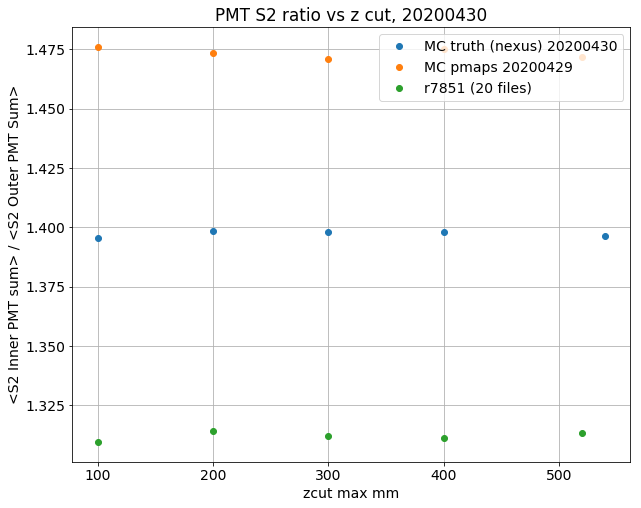

In [213]:
# This is all for nexus 20200430
s1_nexus_ratio = [ 1.4068563364184972, 1.4643145976546703, 1.5066579576325283, 1.5853567270913023, 1.670609182245962]
s2_nexus_ratio = [ 1.3953946270208712, 1.398400650517535, 1.3981212172562794, 1.3980097084622904,1.3964253926439243 ]
zcut_max_mm = [100, 200, 300, 400, 540]
s1_20200430_pmap_ratio = [1.5619149915605337, 1.5553153611393693, 1.5861481086840703, 1.7125425964603715, 1.8356940509915014]
s2_20200430_pmap_ratio = [1.5933678693516364, 1.5911776925703018, 1.5930623810616107, 1.5913629289436746, 1.5884343995571557]

plt.plot(zcut_max_mm, s1_nexus_ratio, 'o', label = 'MC truth (nexus) 20200430')
plt.plot(zcuts[1:], s1_ratios_mc, 'o', label = 'MC pmaps '+mc_date)
plt.plot(zcuts[1:], s1_ratios_data, 'o', label = 'r7851 (20 files)')
plt.grid()
plt.xlabel('zcut max mm')
plt.ylabel('<S1 Inner PMT sum> / <S1 Outer PMT Sum>')
plt.title('PMT S1 ratio vs z cut, 20200430')
plt.legend()
plt.show()

plt.plot(zcut_max_mm, s2_nexus_ratio, 'o', label = 'MC truth (nexus) 20200430')
plt.plot(zcuts[1:], ratios_mc, 'o', label = 'MC pmaps '+mc_date)
plt.plot(zcuts[1:], ratios_data, 'o', label = 'r7851 (20 files)')
plt.grid()
plt.xlabel('zcut max mm')
plt.ylabel('<S2 Inner PMT sum> / <S2 Outer PMT Sum>')
plt.title('PMT S2 ratio vs z cut, 20200430')
plt.legend()
plt.show()